## Take care of relative paths

In [1]:
# Here we take care of paths.
# Make sure root project directory is named 'VESUVIUS_Challenge' for this to work

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in the root folder of the project
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge/jupyter notebooks
Current path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge


### Importing modules and packages

In [2]:
import torch
import monai
from monai.visualize import matshow3d
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import Tuple, List
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from Data_Modules.Vesuvius_Dataset import Vesuvius_Tile_Datamodule
from lit_models.Vesuvius_Lit_Model import Lit_Model
from pytorch_lightning.callbacks import ModelCheckpoint




2023-05-11 11:47:56,827 - Created a temporary directory at /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmp9qtk59jp
2023-05-11 11:47:56,827 - Writing /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmp9qtk59jp/_remote_module_non_scriptable.py


### The following contains 'mps' as accelerator device for Apple M1 gpu


- ***Note: works with pytorch lightning version <2.0***


## Define config file, which will serve as hyperparameter sweep file

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# change to the line below if not using Apple's M1 or chips
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
PATCH_SIZE = 224
Z_DIM = 4
COMPETITION_DATA_DIR_str =  "kaggle/input/vesuvius-challenge-ink-detection/"

class CFG:
    
    device = DEVICE
    
    THRESHOLD = 0.4
    use_wandb = False
    
    ######### Dataset #########
    
    # stage: 'train' or 'test'
    stage = 'train' 
    
    # location of competition Data
    competition_data_dir = COMPETITION_DATA_DIR_str
    
    # Number of slices in z-dim: 1<z_dim<65
    z_dim = Z_DIM
    
    # fragments to use for training avalaible [1,2,3]
    train_fragment_id=[2,3]
    
    # fragments to use for validation
    val_fragment_id=[1]
    
    

    
    
    batch_size = 4
    
    # Size of the patch and stride for feeding the model
    patch_size = PATCH_SIZE
    stride = patch_size // 2
    
    
    num_workers = 0
    on_gpu = True
    
    
    ######## Model and Lightning Model paramters ############
    
    # MODEL
    model = monai.networks.nets.FlexibleUNet(in_channels=z_dim,
                                         out_channels=1,
                                         backbone='efficientnet-b3',
                                         pretrained=True,
                                         decoder_channels=(512, 256, 128, 64, 32),
                                         spatial_dims=2,
                                         norm=('instance', {'eps': 0.001, 'momentum': 0.1}),
                                         # act=('relu', {'inplace': True}),
                                         act=None,
                                         dropout=0.0,
                                         decoder_bias=False,
                                         upsample='deconv',
                                         interp_mode='nearest',
                                         is_pad=False)
    
    
    
    
    
    checkpoint = None
    save_directory = None
    
    
    accumulate_grad_batches = 48 # experiments showed batch_size * accumulate_grad = 192 is optimal
    learning_rate = 0.0001
    eta_min = 5e-7
    t_max = 50
    max_epochs = 60
    weight_decay =  0.00001
    precision =16
    
    # checkpointing
    save_top_k=5
    
    monitor="FBETA"
    mode="max"
    
    
    ####### Augemtnations ###############
    
    # Training Aug
    train_transforms = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(patch_size, patch_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(patch_size * 0.3), max_height=int(patch_size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    

    
    # Validaiton Aug
    val_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    
    # Test Aug
    test_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean=[0] * z_dim,
            std=[1] * z_dim
        ),

        ToTensorV2(transpose_mask=True),
    ]
        
    
    

### Initialize dataset

In [5]:
dataset = Vesuvius_Tile_Datamodule(cfg=CFG)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

### Looking under the hood (sanity check)

##### plots only  the first z_slice of the volumes

subvolume shape: torch.Size([4, 4, 224, 224])
inklabel shape: torch.Size([4, 1, 224, 224])
binary_mask torch.Size([4, 1, 224, 224])


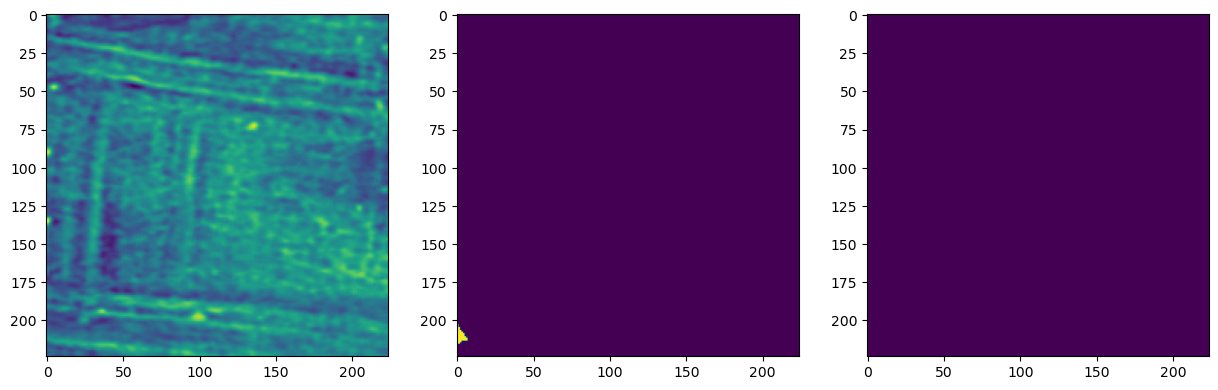

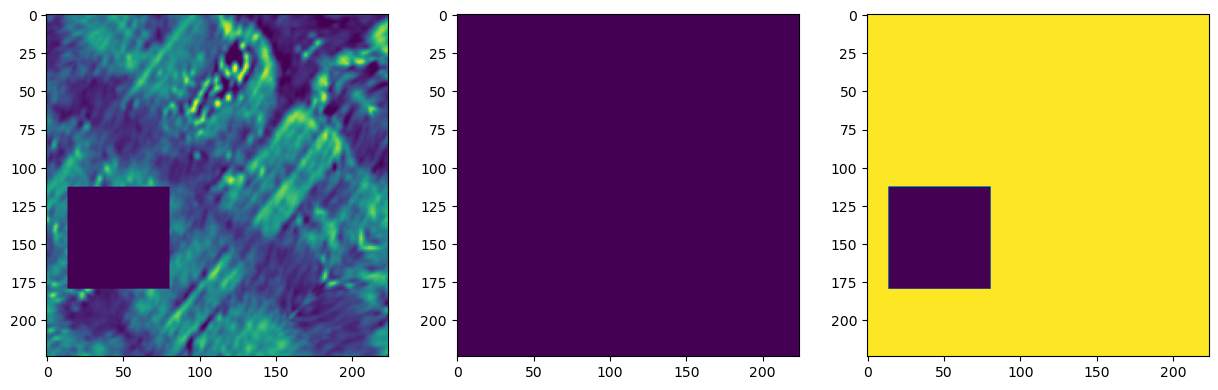

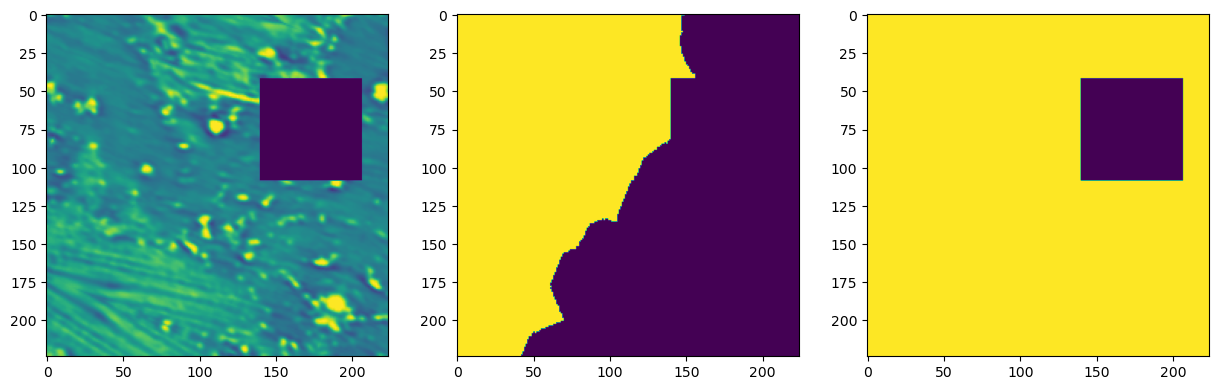

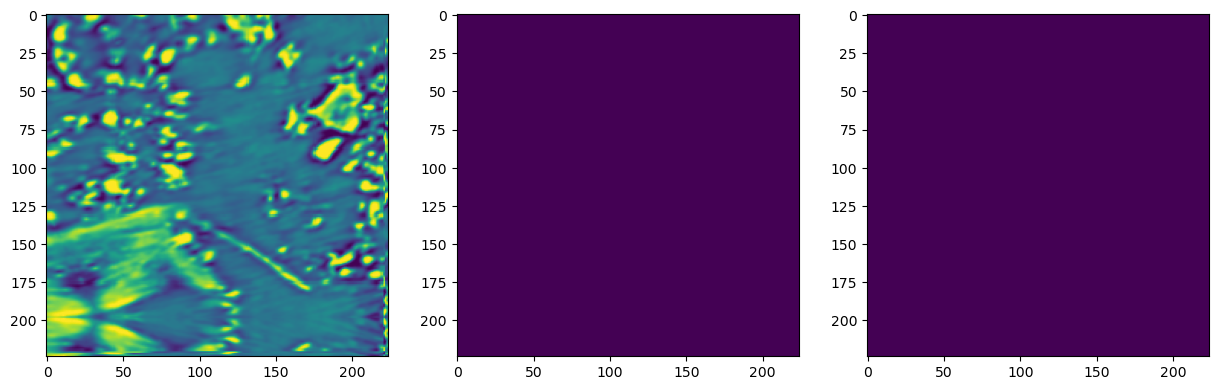

In [17]:
BATCHES_to_SHOW = 1

dataloader = iter(dataset.train_dataloader())
for i in range(BATCHES_to_SHOW):
    # Get image and label from train data -- change number for different ones
    subvolumes, inklabels, binary_masks = next(dataloader)
    print('subvolume shape:',subvolumes.shape)
    print('inklabel shape:',inklabels.shape)
    print('binary_mask', masks.shape )
    
    for subvolume,  inklabel, binary_mask in zip(subvolumes, inklabels, binary_masks):
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                for idx, image in enumerate((subvolume,  inklabel, binary_mask)):
                    if idx==0:
                        axes[idx].imshow(image[0])
                    else:
                         axes[idx].imshow(image.squeeze(0))

                plt.show()
                
                


### 3D version check
- combines two slices together

In [8]:
# taken from https://www.kaggle.com/code/clemchris/vesuvis-pytorch-monai
def visualize_dataloaders(dataloaders, train=True):
    for stage, dataloader in dataloaders.items():
        for batch_idx, batch in enumerate(dataloader):
            volumes, labels = batch
           
            out = [volumes, labels]
            for volume,  label in zip(volumes,  labels):
                fig, axes = plt.subplots(1, 2, figsize=(10, 3))
                plt.suptitle(f"stage: {stage}, fragment: {batch_idx}")

                for idx, image in enumerate((volume, label)):
                    matshow3d(
                        volume=image,
                        fig=axes[idx],
                        title=f"{list(image.shape)}, {image.min().item()}, {image.max().item()}",
                        vmin=0.0,
                        vmax=1.0,
                        every_n=2,
                        fill_value=1.0,
                        margin=4,
                        cmap="gray",
                    )
            return out

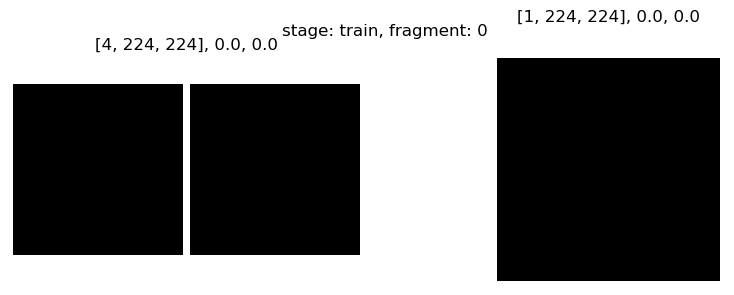

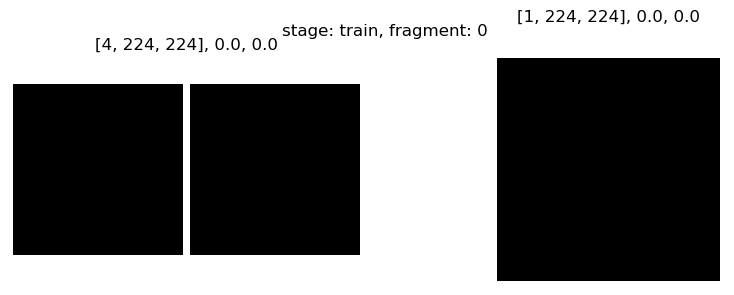

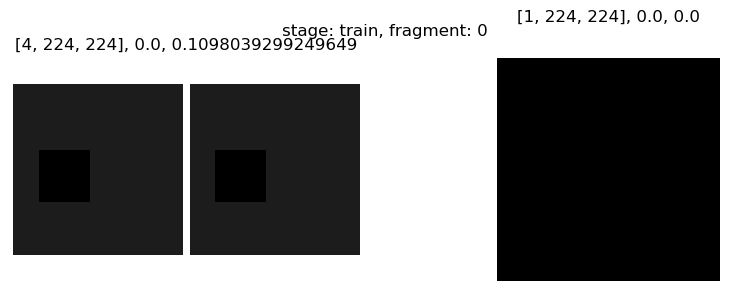

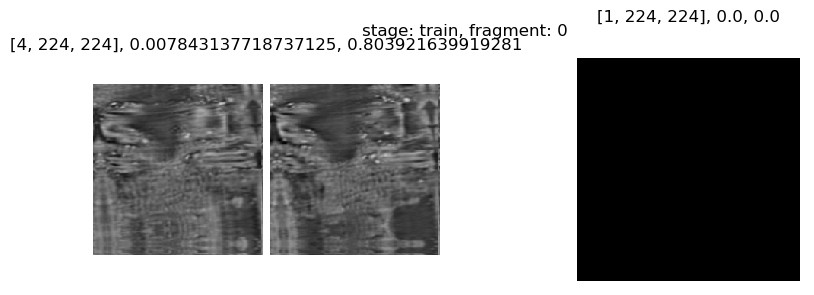

In [9]:
dataloaders = {
    "train": dataset.train_dataloader(),
    "val": dataset.val_dataloader(),
}

batch = visualize_dataloaders(dataloaders)

### Inititate Lit model

In [10]:
lit_model = Lit_Model(cfg=CFG,)
    

### Training

In [11]:
SAVE_DIR = 'logs/Test'

checkpoint_callback = ModelCheckpoint(
    save_top_k=5,
    monitor="FBETA",
    mode="max",
    dirpath=SAVE_DIR,
    filename="TEST_MODEL{epoch:02d}{FBETA:.2f}{val_loss:.2f}{fbeta_4:.2f}{recall:.2f}{precision:.2f}",
    save_last =True,
)


trainer = pl.Trainer(
        accelerator='mps',
        #benchmark=True,
        max_epochs=CFG.max_epochs,
        check_val_every_n_epoch= 1,
        devices=1,
        #fast_dev_run=fast_dev_run,
        logger=pl.loggers.CSVLogger(save_dir=SAVE_DIR),
        log_every_n_steps=1,
        default_root_dir = SAVE_DIR,
        #overfit_batches=1,
        precision=CFG.precision,
        accumulate_grad_batches=CFG.accumulate_grad_batches, 
        callbacks=[checkpoint_callback],
        #resume_from_checkpoint ='logs/MoUB3_Bce05+05Tver_instance/last.ckpt'
        
        )





trainer.fit(lit_model, datamodule=dataset,
            #ckpt_path='logs/Local_Originalgood/last.ckpt'
           )

2023-05-07 14:44:07,712 - Using 16bit None Automatic Mixed Precision (AMP)
2023-05-07 14:44:07,740 - GPU available: True (mps), used: True
2023-05-07 14:44:07,741 - TPU available: False, using: 0 TPU cores
2023-05-07 14:44:07,741 - IPU available: False, using: 0 IPUs
2023-05-07 14:44:07,741 - HPU available: False, using: 0 HPUs


/Users/gregory/anaconda3/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/Users/gregory/anaconda3/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /Users/gregory/PROJECT_ML/VESUVIUS_Challenge/logs/Test exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Adjusting learning rate of group 0 to 1.0000e-04.
2023-05-07 14:44:08,041 - 
  | Name                  | Type                  | Params
----------------------------------------------------------------
0 | metrics               | ModuleDict            | 0     
1 | model                 | FlexibleUNet          | 18.8 M
2 | loss_dice             | DiceLoss              | 0     
3 | loss_tversky          | TverskyLoss           | 0     
4 | loss_focal            | FocalLoss             | 0     
5 | loss_bce              | SoftBCEWithLogitsLoss | 0     
6 | loss_monai_focal_dice | DiceFocalLoss         | 0     
----------------------------------------------------------------
18.8 M    Trainable params
0         Non-trainable params
18.8 M    Total params
37.684    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/gregory/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/torch/amp/autocast_mode.py:221: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/gregory/anaconda3/lib/python3.10/site-packages/segmentation_models_pytorch/metrics/functional.py:214: UserWarning: MPS: no support for int64 for sum_out_mps, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/runner/work/_temp/anacon

Training: 0it [00:00, ?it/s]

/Users/gregory/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
